## Titanic Survival Predicton

#### The objective is to predict if passanger has survived or not.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train dataset has {} samples and {} attributes".format(*train.shape))
print("Test dataset has {} samples and {} attributes".format(*test.shape))

Train dataset has 891 samples and 12 attributes
Test dataset has 418 samples and 11 attributes


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### We have 11 feature columns and target variable Survived which is binary.
#### Pclass, Sex and Embarked are Categorical Features while Age, SibSp, Parch and Fare are continuous variables.
#### We will use Name, Ticket and Cabin variable in Feature Engineering.

### EDA(Exploratory Data Analysis)

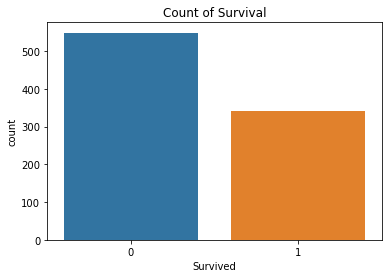

In [4]:
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title("Count of Survival")
plt.show()

In [5]:
n=len(train)
surv_0=len(train[train['Survived']==0])
surv_1=len(train[train['Survived']==1])

print("% of passanger survived in train dataset: ",surv_1*100/n)
print("% of passanger not survived in train dataset: ",surv_0*100/n)

% of passanger survived in train dataset:  38.38383838383838
% of passanger not survived in train dataset:  61.61616161616162


#### Passanger not survived has edge over survived passanger.
#### And even if we do nothing we would get approximately 61% accuracy by simple marking all passangers as not survived(Accuracy Paradox). So our aim should be to get accuracy higher than this.

### Let's find correlation between Numeric Variable

In [6]:
cat=['Pclass','Sex','Embarked']
num=['Age','SibSp','Parch','Fare']

In [7]:
train.select_dtypes(exclude='object')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000
887,888,1,1,19.0,0,0,30.0000
888,889,0,3,NaN,1,2,23.4500
889,890,1,1,26.0,0,0,30.0000


In [8]:
corr_df=train[num]  
# New dataframe to calculate correlation between numeric features
cor = corr_df.corr(method='pearson')
print(cor)

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


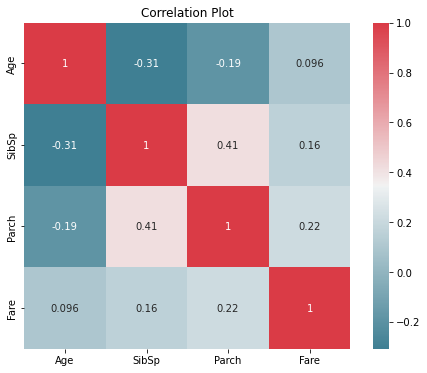

In [9]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

#### There's no strong correlation between any two variables. The strongest correlation is between SibSp and Parch features (0.414).
#### I would like to keep all the features as there is no strong evidence of data redundancy.

### Let's use chi-square test to understand relationship between categorical variables and target variable

In [10]:
csq = chi2_contingency(pd.crosstab(train['Survived'], train['Sex']))
print("P-value: ",csq[1])

P-value:  1.1973570627755645e-58


In [11]:
csq2 = chi2_contingency(pd.crosstab(train['Survived'], train['Embarked']))
print("P-value: ",csq2[1])

P-value:  1.769922284120912e-06


In [12]:
csq3 = chi2_contingency(pd.crosstab(train['Survived'], train['Pclass']))
print("P-value: ",csq3[1])

P-value:  4.549251711298793e-23


#### P values for features Sex, Embarked and Pclass are very low. So we can reject our Null Hypothesis which is these features are independent and have no relationship with target variable
#### So these features contribute by providing some information.

### Visualization

#### First Let's check the impact of feature Sex on Survived

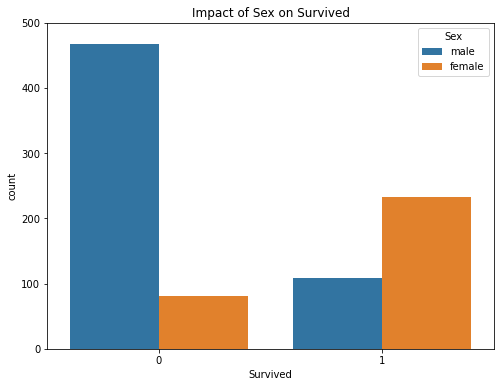

In [13]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Sex')
ax.set_ylim(0,500)
plt.title("Impact of Sex on Survived")
plt.show()

#### We can say that Female passangers have higher probability of survival than Male passangers

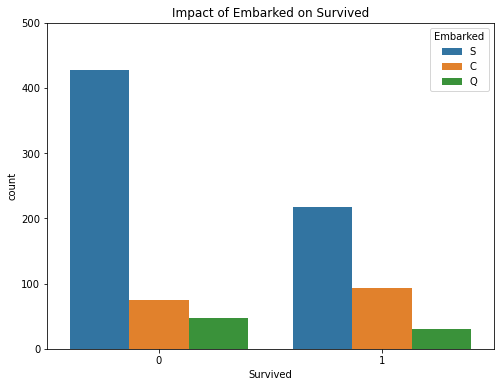

In [14]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Impact of Embarked on Survived")
plt.show()

#### Ratio of Survived and Not Survived passangers for S and Q Embarked are similar but Passengers from C embarked have higer chances of survival.

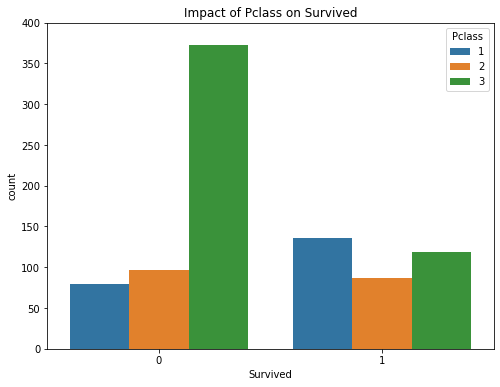

In [15]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train, hue='Pclass')
ax.set_ylim(0,400)
plt.title("Impact of Pclass on Survived")
plt.show()

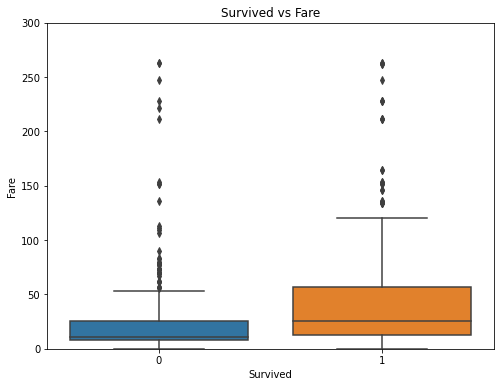

In [16]:
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Fare', data=train)
ax.set_ylim(0,300)
plt.title("Survived vs Fare")
plt.show()

#### Average Fare for passangers who survived is higher than not survived.

### Handling Missing Values

#### Let's check which features contain missing values

In [17]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [18]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### Only 4 features have missing values

### Age

In [19]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### Let's replace missing values by median of Age.

In [20]:
med = np.nanmedian(train['Age'])
train['Age'] = train['Age'].fillna(med)
test['Age'] = test['Age'].fillna(med)

### Cabin

In [21]:
train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

#### Let's replace NaN by 0

In [22]:
train['Cabin']=train['Cabin'].fillna(0)
test['Cabin']=test['Cabin'].fillna(0)

### Embarked

In [23]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### Let's replace the NaN by mode

In [24]:
train['Cabin']=train['Cabin'].fillna("S")

### Fare

In [25]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

#### Let's replace the NaN by median

In [26]:
med = np.nanmedian(train['Fare'])
test['Fare']=test['Fare'].fillna(med)

### Feature Engineering

#### from cabin let's create a new feature hasCabin

In [27]:
train.Cabin[:10]

0       0
1     C85
2       0
3    C123
4       0
5       0
6     E46
7       0
8       0
9       0
Name: Cabin, dtype: object

In [28]:
train['hasCabin']=train['Cabin'].apply(lambda x: 0 if x==0 else 1)
test['hasCabin']=test['Cabin'].apply(lambda x: 0 if x==0 else 1)

In [29]:
train.hasCabin[:10]

0    0
1    1
2    0
3    1
4    0
5    0
6    1
7    0
8    0
9    0
Name: hasCabin, dtype: int64

#### Let's combine SibSp and Parch features to create new one FamilyMem

In [30]:
train[['SibSp','Parch']]

,SibSp,Parch
0,1,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
886,0,0
887,0,0
888,1,2
889,0,0


In [31]:
train['FamilyMem']=train.apply(lambda x: x['SibSp']+x['Parch'], axis=1)
test['FamilyMem']=test.apply(lambda x: x['SibSp']+x['Parch'], axis=1)

#### Let's use prefixes in the name to Create a new column Title

In [32]:
train.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [33]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [34]:
train['title']=train['Name'].apply(get_title)
test['title']=test['Name'].apply(get_title)

In [35]:
train.title

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: title, Length: 891, dtype: object

In [36]:
print(dir(re))

['A', 'ASCII', 'DEBUG', 'DOTALL', 'I', 'IGNORECASE', 'L', 'LOCALE', 'M', 'MULTILINE', 'Match', 'Pattern', 'RegexFlag', 'S', 'Scanner', 'T', 'TEMPLATE', 'U', 'UNICODE', 'VERBOSE', 'X', '_MAXCACHE', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_cache', '_compile', '_compile_repl', '_expand', '_locale', '_pickle', '_special_chars_map', '_subx', 'compile', 'copyreg', 'enum', 'error', 'escape', 'findall', 'finditer', 'fullmatch', 'functools', 'match', 'purge', 'search', 'split', 'sre_compile', 'sre_parse', 'sub', 'subn', 'template']


In [37]:
help(re.search)

Help on function search in module re:

search(pattern, string, flags=0)
    Scan through string looking for a match to the pattern, returning
    a Match object, or None if no match was found.



In [38]:
list(train['title'].value_counts().reset_index()['index'])

['Mr',
 'Miss',
 'Mrs',
 'Master',
 'Dr',
 'Rev',
 'Mlle',
 'Major',
 'Col',
 'Countess',
 'Capt',
 'Ms',
 'Sir',
 'Lady',
 'Mme',
 'Don',
 'Jonkheer']

In [39]:
title_lev1=list(train['title'].value_counts().reset_index()['index'])
title_lev2=list(test['title'].value_counts().reset_index()['index'])

In [40]:
title_lev=list(set().union(title_lev1, title_lev2))
print(title_lev)

['Mlle', 'Capt', 'Dr', 'Rev', 'Mrs', 'Don', 'Jonkheer', 'Dona', 'Mr', 'Sir', 'Countess', 'Master', 'Mme', 'Major', 'Lady', 'Ms', 'Col', 'Miss']


### Assigning datatypes

In [41]:
train['title']=pd.Categorical(train['title'], categories=title_lev)
test['title']=pd.Categorical(test['title'], categories=title_lev)

In [42]:
train.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
hasCabin          int64
FamilyMem         int64
title          category
dtype: object

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     889 non-null    object  
 12  hasCabin     891 non-null    int64   
 13  FamilyMem    891 non-null    int64   
 14  title        891 non-null    category
dtypes: category(1), float64(2), int64(7), object(5)
memory usage: 99.1+ KB


In [44]:
train.PassengerId = train.PassengerId.astype('int16')

In [45]:
int_col = train.select_dtypes('int64').columns
int_col

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'hasCabin', 'FamilyMem'], dtype='object')

In [46]:
for i in int_col:
    # print(i)
    train[i] = train[i].astype('int16')

In [47]:
train.dtypes

PassengerId       int16
Survived          int16
Pclass            int16
Name             object
Sex              object
Age             float64
SibSp             int16
Parch             int16
Ticket           object
Fare            float64
Cabin            object
Embarked         object
hasCabin          int16
FamilyMem         int16
title          category
dtype: object

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    int16   
 2   Pclass       891 non-null    int16   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int16   
 7   Parch        891 non-null    int16   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     889 non-null    object  
 12  hasCabin     891 non-null    int16   
 13  FamilyMem    891 non-null    int16   
 14  title        891 non-null    category
dtypes: category(1), float64(2), int16(7), object(5)
memory usage: 62.6+ KB


In [49]:
cols =['Pclass','Sex','Embarked','hasCabin','title']
fcol =['Pclass','Sex','Embarked','hasCabin','title','Age','FamilyMem','Fare']

In [50]:
for c in cols:
    train[c]=train[c].astype('category')
    test[c]=test[c].astype('category')

### Let's create dummy variables

In [51]:
train_df = train[fcol]
test_df = test[fcol]

In [52]:
train_df = pd.get_dummies(train_df, columns=cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=cols, drop_first=True)

In [53]:
y = train['Survived']

### Model

In [54]:
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=42)

### Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
rfc = RandomForestClassifier(random_state=42)
rfc

RandomForestClassifier(random_state=42)

In [57]:
param_grid = { 
    'n_estimators': [50,100,200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [58]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 300]})

In [59]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100}

In [60]:
CV_rfc.best_estimator_

RandomForestClassifier(max_depth=7, random_state=42)

In [61]:
rfc1 = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 300, max_depth=5, criterion='entropy')
rfc1

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=300,
                       random_state=42)

In [62]:
rfc1.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=300,
                       random_state=42)

In [63]:
pred=rfc1.predict(x_test)

In [64]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8246268656716418


In [65]:
op_rf = rfc1.predict(test_df)
op_rf

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [66]:
op = pd.DataFrame(test['PassengerId'])
op['Survived'] = op_rf

In [67]:
op.to_csv("op_rf.csv", index=False)

In [68]:
rfc1

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=300,
                       random_state=42)

### Cross_validation

In [69]:
from sklearn.model_selection import cross_val_score

In [70]:
score = cross_val_score(estimator=rfc1,X=train_df,y=y,cv=5)
score

array([0.83240223, 0.83146067, 0.82022472, 0.80337079, 0.84831461])

In [71]:
import numpy as np
np.mean(score)*100

82.7154604230745